# Nama : Elsa Elisa Yohana Sianturi
# NIM : 122140135

# Install Library

In [1]:
!pip install timm seaborn tqdm


# Import Library

In [2]:
import os
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


# Import library PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

# Cek  GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU terdeteksi:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU tidak tersedia, menggunakan CPU")

device

GPU terdeteksi: Tesla T4


device(type='cuda')

# Load dataset & encode label

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   filename      label
0  0001.jpg  gado_gado
1  0002.jpg  gado_gado
2  0003.jpg    rendang
3  0004.jpg      bakso
4  0005.jpg      bakso


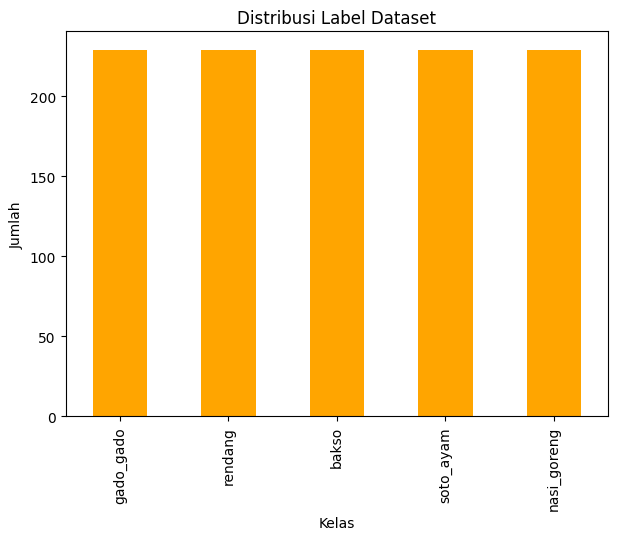

Jumlah Data Train: 916
Jumlah Data Validasi: 229
Persentase Data Train     : 80.00%
Persentase Data Validasi  : 20.00%


5

In [3]:
from google.colab import drive
drive.mount('/content/drive')

csv_path = "/content/drive/MyDrive/Tugas2/label.csv"
img_dir  = "/content/drive/MyDrive/Tugas2/dataset/"
df = pd.read_csv(csv_path)
print(df.head())

# Visualisasi distribusi kelas
plt.figure(figsize=(7,5))
df['label'].value_counts().plot(kind='bar', color='orange')
plt.title("Distribusi Label Dataset")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Encode label
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Split train dan validation
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_encoded']
)

print("Jumlah Data Train:", len(train_df))
print("Jumlah Data Validasi:", len(val_df))

# Hitung persentase
total = len(df)
train_percent = (len(train_df) / total) * 100
val_percent   = (len(val_df) / total) * 100

print(f"Persentase Data Train     : {train_percent:.2f}%")
print(f"Persentase Data Validasi  : {val_percent:.2f}%")

num_classes = len(label_encoder.classes_)
num_classes


# Class Dataset dan Augmentasi

In [4]:
# Class dataset custom untuk membaca gambar & label
class FoodDataset(Dataset):
    # Dataset ini menerima dataframe, folder gambar, dan transformasi
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    # Mengambil satu data: gambar + label
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['filename'])

        # Baca gambar sebagai RGB (untuk model transformer)
        image = Image.open(img_path).convert("RGB")
        label = row['label_encoded']

        # Jika ada augmentasi maka terapkan
        if self.transform:
            image = self.transform(image)

        return image, label


# Augmentasi untuk training
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Transformasi validasi (tanpa augmentasi)
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

# Membuat dataset & loader
train_ds = FoodDataset(train_df, img_dir, train_tf)
val_ds   = FoodDataset(val_df, img_dir, val_tf)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)


# Konfigurasi training

In [5]:
# hyper parameter yang dibutuhkan
config = {
    "epochs": 12,
    "lr": 1e-4,
    "batch_size": 16,
    "patience": 3, # untuk early stopping
    "device": device,
    "save_path": "/content/drive/MyDrive/Tugas2/result/"
}

# Membuat folder hasil jika belum ada
os.makedirs(config["save_path"], exist_ok=True)

config


{'epochs': 12,
 'lr': 0.0001,
 'batch_size': 16,
 'patience': 3,
 'device': device(type='cuda'),
 'save_path': '/content/drive/MyDrive/Tugas2/result/'}

# Load Model

In [6]:
# Fungsi untuk menghitung parameter
def count_params(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

# Load model DeiT Base
model_deit = timm.create_model(
    "deit_base_patch16_224",
    pretrained=True,
    num_classes=num_classes
)

# Freeze semua layer kecuali head
for name, param in model_deit.named_parameters():
    param.requires_grad = "head" in name

print("Trainable DeiT")
print(count_params(model_deit))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Trainable DeiT
(3845, 85802501)


# Fungsi Training dan early stopping

In [7]:
def train_model(model, train_loader, val_loader, config, model_name):
    model.to(config["device"])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config["lr"]
    )

    best_loss = float("inf")
    patience_counter = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(config["epochs"]):
        model.train()
        train_loss, correct_train = 0, 0

        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        #  Progress bar untuk TRAINING
        for x, y in tqdm(train_loader, desc=f"Training {model_name}"):
            x, y = x.to(config["device"]), y.to(config["device"])

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == y).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct_train / len(train_loader.dataset)


        model.eval()
        val_loss, correct_val = 0, 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc=f"Validation {model_name}"):
                x, y = x.to(config["device"]), y.to(config["device"])
                outputs = model(x)
                val_loss += criterion(outputs, y).item()
                correct_val += (outputs.argmax(1) == y).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct_val / len(val_loader.dataset)

        # Simpan history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[{model_name}] TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} "
              f"TrainAcc={train_acc:.4f} ValAcc={val_acc:.4f}")

        # SImpan model
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"{config['save_path']}/{model_name}_best.pth")
            print(f"Model terbaik {model_name} disimpan!")
        else:
            patience_counter += 1

        if patience_counter >= config["patience"]:
            print("Early stopping aktif!")
            break

    return model, history


# Training Model

In [9]:
history_dict = {}
model_deit, hist_deit = train_model(model_deit, train_loader, val_loader, config, "deit")
history_dict["deit"] = hist_deit


Epoch 1/12


Training deit:  40%|███▉      | 23/58 [00:16<00:28,  1.25it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


[deit] TrainLoss=0.3020 ValLoss=0.3095 TrainAcc=0.9454 ValAcc=0.9389
Model terbaik deit disimpan!

Epoch 2/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


[deit] TrainLoss=0.2683 ValLoss=0.2839 TrainAcc=0.9607 ValAcc=0.9432
Model terbaik deit disimpan!

Epoch 3/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


[deit] TrainLoss=0.2609 ValLoss=0.2689 TrainAcc=0.9520 ValAcc=0.9476
Model terbaik deit disimpan!

Epoch 4/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


[deit] TrainLoss=0.2379 ValLoss=0.2529 TrainAcc=0.9629 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 5/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


[deit] TrainLoss=0.2230 ValLoss=0.2410 TrainAcc=0.9651 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 6/12


Validation deit: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


[deit] TrainLoss=0.2022 ValLoss=0.2297 TrainAcc=0.9727 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 7/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


[deit] TrainLoss=0.1810 ValLoss=0.2211 TrainAcc=0.9749 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 8/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


[deit] TrainLoss=0.1792 ValLoss=0.2123 TrainAcc=0.9738 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 9/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


[deit] TrainLoss=0.1718 ValLoss=0.2047 TrainAcc=0.9727 ValAcc=0.9520
Model terbaik deit disimpan!

Epoch 10/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


[deit] TrainLoss=0.1623 ValLoss=0.1980 TrainAcc=0.9793 ValAcc=0.9563
Model terbaik deit disimpan!

Epoch 11/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


[deit] TrainLoss=0.1670 ValLoss=0.1929 TrainAcc=0.9727 ValAcc=0.9520
Model terbaik deit disimpan!

Epoch 12/12


Validation deit: 100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


[deit] TrainLoss=0.1541 ValLoss=0.1846 TrainAcc=0.9803 ValAcc=0.9563
Model terbaik deit disimpan!


# Plot Kurva

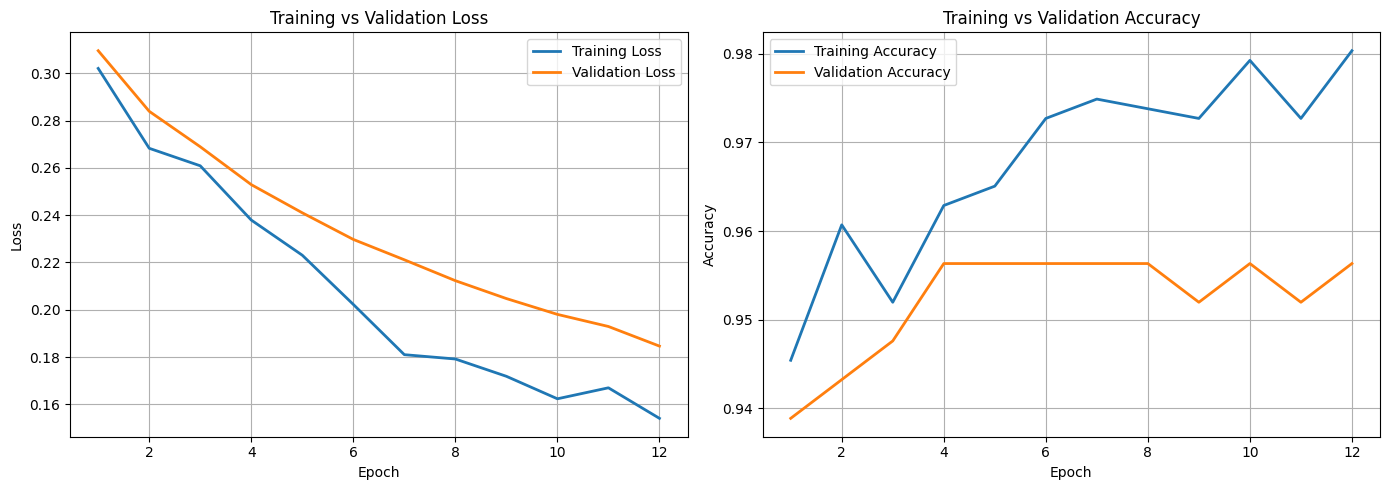

In [10]:
hist = history_dict["deit"]

# Ambil data
train_loss = hist["train_loss"]
val_loss = hist["val_loss"]
train_acc = hist["train_acc"]
val_acc = hist["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))


# Kurva LOSS
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Training Loss", linewidth=2)
plt.plot(epochs, val_loss, label="Validation Loss", linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()


# Kurva ACCURACY
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Training Accuracy", linewidth=2)
plt.plot(epochs, val_acc, label="Validation Accuracy", linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluasi

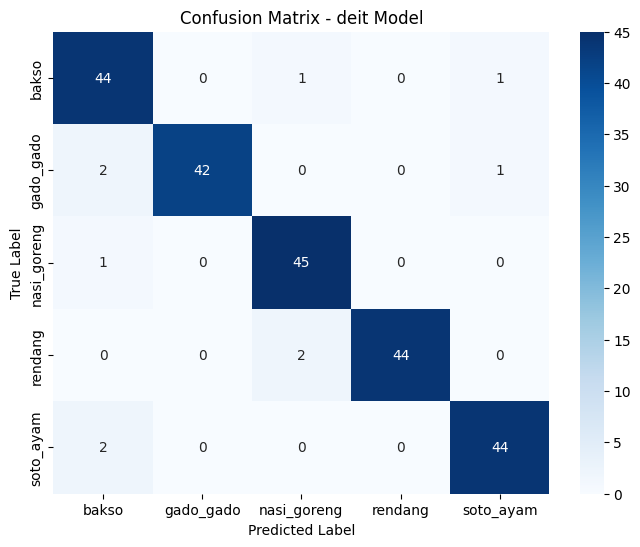

Classification Report:
              precision    recall  f1-score   support

       bakso       0.90      0.96      0.93        46
   gado_gado       1.00      0.93      0.97        45
 nasi_goreng       0.94      0.98      0.96        46
     rendang       1.00      0.96      0.98        46
   soto_ayam       0.96      0.96      0.96        46

    accuracy                           0.96       229
   macro avg       0.96      0.96      0.96       229
weighted avg       0.96      0.96      0.96       229



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#   Confusion matrix

model_deit.eval()
model_deit.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        outputs = model_deit(x)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# Hitung confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = label_encoder.classes_
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - deit Model")
plt.show()

#  CLASSIFICATION REPORT
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels))


# Pengukuran Waktu Interfensi

In [12]:
import time
import numpy as np
from tqdm import tqdm
from PIL import Image

def measure_inference_deit(model, model_name="swin", n_samples=100):

    # Pengambilan sampel acak dari validation set
    sample_df = val_df.sample(min(n_samples, len(val_df)))
    times = []
    model.eval()

    with torch.no_grad():
        # Loop setiap gambar
        for _, row in tqdm(sample_df.iterrows(),
                           total=len(sample_df),
                           desc=f"Inference {model_name}",
                           leave=True):

            # Load gambar
            img = Image.open(os.path.join(img_dir, row["filename"])).convert("RGB")
            img = val_tf(img).unsqueeze(0).to(device)

            # Jalankan inferensi & hitung waktu
            start = time.time()
            _ = model(img)
            end = time.time()

            times.append(end - start)

    # Waktu rata-rata per gambar (dalam milidetik)
    avg_ms = np.mean(times) * 1000
    total_sec = np.sum(times)
    throughput = len(times) / total_sec

    print(f"\n Inference Time ({model_name}) ")
    print(f"Jumlah sampel                 : {len(times)} gambar")
    print(f"Rata-rata waktu per gambar    : {avg_ms:.3f} ms")
    print(f"Total waktu inferensi         : {total_sec:.4f} detik")
    print(f"Throughput                    : {throughput:.2f} gambar/detik\n")

    return avg_ms, total_sec, throughput
measure_inference_deit(model_deit, "deit", n_samples=100)

Inference deit: 100%|██████████| 100/100 [00:05<00:00, 19.94it/s]


 Inference Time (deit) 
Jumlah sampel                 : 100 gambar
Rata-rata waktu per gambar    : 7.718 ms
Total waktu inferensi         : 0.7718 detik
Throughput                    : 129.56 gambar/detik



(np.float64(7.718243598937988),
 np.float64(0.7718243598937988),
 np.float64(129.56315607058548))

In [13]:
!nvidia-smi
print("PyTorch CUDA Version:", torch.version.cuda)
print("GPU Available:", torch.cuda.is_available())


Fri Nov 21 05:09:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             34W /   70W |     708MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----